# Revisiting the time dependence of SEI growth
## Peter Attia, September 6, 2019
This notebook is used to generate Figures 2–4 of the associated publication

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
import glob
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

In [2]:
# set plotting settings
fig_size = (3.25,8.66) #ECS spec is 3.25" width
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'

colors = cm.viridis(np.linspace(0, 1, 4))
colors = colors[:,0:3]

## Illustration
First, we illustrate how $t^{0.5}$ models can "look good" but still not capture the true functional form.

In [3]:
# Define fitting functions
def t_onehalf(x, a, b):
    return a * x**0.5 + b

def power1(x, a, b):
    return a * x**b

def power2(x, a, b, c):
    return a * x**b + c

In [4]:
# Define wrapper function for curve fit that also returns R^2 since it's not returned by default
# https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
def curve_fit_with_r_squared(f, xdata, ydata):
    popt, pcov = curve_fit(f, xdata, ydata)
    
    residuals = ydata - f(xdata, *popt)
    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((ydata-np.mean(ydata))**2)

    r_squared = 1 - (ss_res / ss_tot)
    
    return popt, pcov, r_squared

def adj_r_squared(r_squared, n, p):
    return r_squared - (p-1)/(n-p)*(1-r_squared)

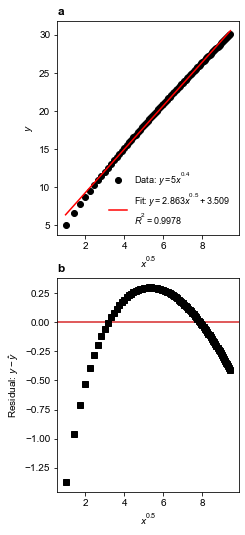

In [5]:
x = np.arange(1,90) # example data
y = 5*x**0.4

popt, pcov, r_squared = curve_fit_with_r_squared(t_onehalf, x, y)

plt.subplots(figsize=fig_size, nrows=2)
plt.subplot(211)
plt.title('a',loc='left',weight='bold')

plt.plot(np.sqrt(x),y,'ko',
         label='Data: ' + r'$y=5x^{0.4}$')
plt.plot(np.sqrt(x), t_onehalf(x, *popt), 'r-',
         label='Fit: '+ r'$y=%5.3fx^{0.5} + %5.3f$' % tuple(popt)+'\n'+r'$R^2=%3.4f$' %(r_squared))
plt.xlabel(r'$x^{0.5}$')
plt.ylabel(r'$y$')
plt.legend(frameon=False,fontsize=9)

plt.subplot(212)
plt.title('b',loc='left',weight='bold')

plt.axhline(0,color='tab:red')
plt.plot(x**0.5,y-t_onehalf(x, *popt),'ks')

plt.xlabel(r'$x^{0.5}$')
plt.ylabel(r'Residual: $y-\hat{y}$')

plt.savefig('fig2.eps',bbox_inches='tight',format='eps')

## Literature data re-analysis
Next, we re-analyze literature data.
The data from the C/10, 30&deg;C series of Figure 7 of [Smith et al.](https://doi.org/10.1149/1.3557892) was extracted with [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) using three different extraction techniques. The figure is reproduced here:<br>
<img src="Smith_et_al_2011_Fig7.png" width="400">

In [6]:
csvs = glob.glob('*.{}'.format('csv')) #two-column array, x=t^0.5, y=Qirr
data = []
data_shape = np.genfromtxt(csvs[0],delimiter=',').shape
x = np.zeros((data_shape[0],3))
y = np.zeros((data_shape[0],3))

for k, csv in enumerate(csvs):
    d = np.genfromtxt(csv,delimiter=',')
    data.append(d)
    x[:,k] = d[:,0]
    y[:,k] = d[:,1]

Text(0, 0.5, '$Q_{irr} (mAh/g)$')

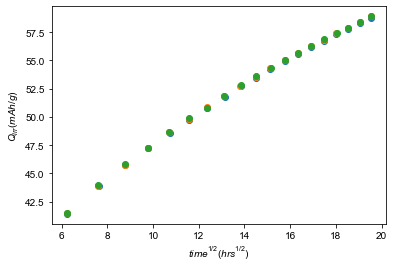

In [7]:
for d in data:
    plt.plot(d[:,0],d[:,1],'o')
plt.xlabel(r'$time^{1/2} (hrs^{1/2})$')
plt.ylabel(r'$Q_{irr} (mAh/g)$')

Triplicate extractions look similar. Next we determine the relative standard error (rse) to quantify the extraction error

Mean relative standard error = 0.095%
Max relative standard error = 0.151%


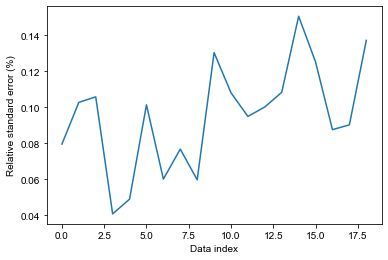

In [8]:
means = np.mean(y,axis=1)
se = 1.96*np.std(y,axis=1)/np.sqrt(3)
rse = se/means*100
plt.plot(rse)
plt.xlabel('Data index')
plt.ylabel('Relative standard error (%)')
print('Mean relative standard error = {:.3f}%'.format(np.mean(rse)))
print('Max relative standard error = {:.3f}%'.format(np.max(rse)))

Extraction errors are quite low. For now we'll assume we can accurately extract the data, although of course there could be systematic extraction errors (we don't have the true values for the true quantification)

In [9]:
x = data[0][:,0]**2 # work with x in units of time, not sqrt(time)
y = data[0][:,1]

popt1,pcov1,r2_1 = curve_fit_with_r_squared(t_onehalf, x, y)
popt2,pcov2,r2_2 = curve_fit_with_r_squared(power1, x, y)
popt3,pcov3,r2_3 = curve_fit_with_r_squared(power2, x, y)

n = len(data[0][:,0])
adj_r_sq1 = adj_r_squared(r2_1, n, 2)
adj_r_sq2 = adj_r_squared(r2_2, n, 2)
adj_r_sq3 = adj_r_squared(r2_2, n, 3)

print('Adjusted R^2 for at^1/2+b: %5.4f' % adj_r_sq1)
print('Adjusted R^2 for at^b: %5.4f' % adj_r_sq2)
print('Adjusted R^2 for at^b+c: %5.4f' % adj_r_sq3)

Adjusted R^2 for at^1/2+b: 0.9913
Adjusted R^2 for at^b: 0.9996
Adjusted R^2 for at^b+c: 0.9996


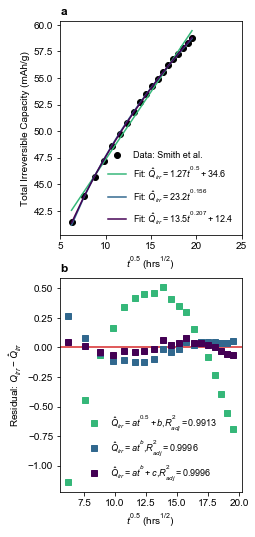

In [10]:
# start plotting
plt.subplots(figsize=fig_size, nrows=2)
plt.subplot(211)
plt.title('a',loc='left',weight='bold')

plt.plot(x**0.5,y,'ko',
         label='Data: Smith et al.')
plt.plot(x**0.5, t_onehalf(x, *popt1), color=colors[2,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%5.2ft^{0.5} + %5.1f$' % tuple(popt1))
plt.plot(x**0.5, power1(x, *popt2), color=colors[1,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%5.1ft^{%5.3f}$' % tuple(popt2))
plt.plot(x**0.5, power2(x, *popt3), color=colors[0,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%5.1ft^{%5.3f} + %5.1f$' % tuple(popt3))

plt.xlabel(r'$t^{0.5}$' + ' (hrs' +r'$^{1/2}$' +')')
plt.xlim((5,25))
plt.ylabel('Total Irreversible Capacity (mAh/g)')
plt.legend(frameon=False,fontsize=9)

## residual analysis
plt.subplot(212)
plt.title('b',loc='left',weight='bold')

plt.axhline(0,color='tab:red')
plt.plot(x**0.5,y-t_onehalf(x, *popt1),'s',color=colors[2,:],
        label=r'$\hat{Q}_{irr}=at^{0.5}+b$'+','+r'$R^2_{adj}=%3.4f$' %(adj_r_sq1))
plt.plot(x**0.5,y-power1(x, *popt2),'s',color=colors[1,:],
        label=r'$\hat{Q}_{irr}=at^{b}$'+','+r'$R^2_{adj}=%3.4f$' %(adj_r_sq2))
plt.plot(x**0.5,y-power2(x, *popt3),'s', color=colors[0,:],
         label=r'$\hat{Q}_{irr}=at^{b}+c$'+','+r'$R^2_{adj}=%3.4f$' %(adj_r_sq3))

plt.xlabel(r'$t^{0.5}$' + ' (hrs' +r'$^{1/2}$' +')')
plt.ylabel('Residual: '+ r'$Q_{irr}-\hat{Q}_{irr}$')
plt.legend(frameon=False,fontsize=9)

plt.savefig('fig3.eps',bbox_inches='tight',format='eps')

Now, try prediction of last 20% of data points, using first 80% of data points for training

In [11]:
threshold = int(np.floor(np.size(data[0][:,0])*0.8)) # train/test threshold for indexing

# split into test/train
x_train = data[0][:threshold,0]**2
y_train = data[0][:threshold,1]
x_test = data[0][threshold:,0]**2
y_test = data[0][threshold:,1]

# fit training data
popt1,pcov1 = curve_fit(t_onehalf, x_train, y_train)
popt2,pcov2 = curve_fit(power1, x_train, y_train)
popt3,pcov3 = curve_fit(power2, x_train, y_train)

# calculate rmse
rmse1 = np.sqrt(mean_squared_error(y_test,t_onehalf(x_test, *popt1)))
rmse2 = np.sqrt(mean_squared_error(y_test,power1(x_test, *popt2)))
rmse3 = np.sqrt(mean_squared_error(y_test,power2(x_test, *popt3)))

print('RMSE for at^1/2+b: %5.4f' % adj_r_sq1)
print('RMSE for at^b: %5.4f' % adj_r_sq2)
print('RMSE for at^b+c: %5.4f' % adj_r_sq3)

RMSE for at^1/2+b: 0.9913
RMSE for at^b: 0.9996
RMSE for at^b+c: 0.9996


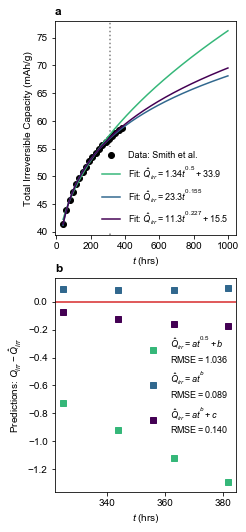

In [12]:
x_future = np.arange(np.min(x_train),1000)

# start plotting
plt.subplots(figsize=fig_size, nrows=2)
plt.subplot(211)
plt.title('a',loc='left',weight='bold')

plt.axvline(np.mean(x[threshold-1:threshold+1]),color='tab:gray',linestyle=':',zorder=0)
plt.plot(x,y,'ko', label='Data: Smith et al.')
plt.plot(x_future, t_onehalf(x_future, *popt1), color=colors[2,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%.2ft^{0.5} + %5.1f$' % tuple(popt1))
plt.plot(x_future, power1(x_future, *popt2), color=colors[1,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%.1ft^{%5.3f}$' % tuple(popt2))
plt.plot(x_future, power2(x_future, *popt3), color=colors[0,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%.1ft^{%5.3f} + %5.1f$' % tuple(popt3))

plt.xlabel(r'$t$'+' (hrs)')
plt.ylabel('Total Irreversible Capacity (mAh/g)')
plt.legend(fontsize=9,framealpha=1,edgecolor='white').set_zorder(1)

## Predictions
plt.subplot(212)
plt.title('b',loc='left',weight='bold')

plt.axhline(0,color='tab:red')
plt.plot(x_test,y_test-t_onehalf(x_test, *popt1),'s', color=colors[2,:],
         label=r'$\hat{Q}_{irr}=at^{0.5}+b$'+'\nRMSE'+r'$=%3.3f$' %(rmse1))
plt.plot(x_test,y_test-power1(x_test, *popt2),'s', color=colors[1,:],
         label=r'$\hat{Q}_{irr}=at^{b}$'+'\nRMSE'+r'$=%3.3f$' %(rmse2))
plt.plot(x_test,y_test-power2(x_test, *popt3),'s', color=colors[0,:],
         label=r'$\hat{Q}_{irr}=at^{b}+c$'+'\nRMSE'+r'$=%3.3f$' %(rmse3))

plt.xlabel(r'$t$'+' (hrs)')
plt.ylabel('Predictions: '+r'$Q_{irr}-\hat{Q}_{irr}$')
plt.legend(frameon=False,fontsize=9)

plt.savefig('fig4.eps',bbox_inches='tight',format='eps')